# Import Character Vocab


In [2]:
import numpy as np
import json
import tensorflow as tf

In [3]:
import requests

char_path = 'https://firebasestorage.googleapis.com/v0/b/ysc-kme-25095.appspot.com/o/vocab.json?alt=media&token=34178ef2-9e62-491f-9fc5-bf2e30a33635'
try:
  CHAR_INDICES
  print('CHAR_INDICES already assigned')
except NameError:
  with requests.Session() as req:
    resp = req.get(char_path)
    CHAR_INDICES = resp.json()
    print("Import CHAR_INDICES succesful!")

Import CHAR_INDICES succesful!


In [4]:
print(CHAR_INDICES)

{' ': 0, '(': 1, ')': 2, ',': 3, '-': 4, '0': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '8': 13, '9': 14, 'A': 15, 'B': 16, 'C': 17, 'D': 18, 'E': 19, 'F': 20, 'G': 21, 'H': 22, 'I': 23, 'J': 24, 'K': 25, 'L': 26, 'M': 27, 'N': 28, 'O': 29, 'P': 30, 'Q': 31, 'R': 32, 'S': 33, 'T': 34, 'U': 35, 'V': 36, 'W': 37, 'X': 38, 'Y': 39, 'Z': 40, 'a': 41, 'b': 42, 'c': 43, 'd': 44, 'e': 45, 'f': 46, 'g': 47, 'h': 48, 'i': 49, 'j': 50, 'k': 51, 'l': 52, 'm': 53, 'n': 54, 'o': 55, 'p': 56, 'q': 57, 'r': 58, 's': 59, 't': 60, 'u': 61, 'v': 62, 'w': 63, 'x': 64, 'y': 65, 'z': 66, '[': 67, ']': 68, '<pad>': 69, '<unk>': 70}


# Preprocessing text data

## look_back

In [5]:
look_back = 10

In [6]:
def create_dataset(text, look_back = look_back):

  """
  take text with label (text that being defined where to cut ('|')) 
  and encode text and make label
  return preprocessed text & preprocessed label
  """
  X, y = [], []
  text = '|' + text
  data = [CHAR_INDICES['<pad>']] * look_back
  for i in range(1, len(text)):
    current_char = text[i]
    before_char = text[i-1]

    if current_char == '|':
      continue
    data = data[1:] + [CHAR_INDICES[current_char]]  # X data

    target = 1 if before_char == '|' else 0  # y data
    X.append(data)
    y.append(target)
  
  return np.array(X), tf.one_hot(y, 2)

In [7]:
def text_pred_preprocessing(text, sequence_len=look_back):
  """
    take unseen (testing) text and encode it with CHAR_DICT
    //It's like create_dataset() but not return label
    return preprocessed text
  """
  X = []
  data = [CHAR_INDICES['<pad>']] * sequence_len
  for char in text:
    char = char if char in CHAR_INDICES else '<unk>'  # check char in dictionary
    data = data[1:] + [CHAR_INDICES[char]]  # X data
    X.append(data)
  return np.array(X)

In [8]:
def word_tokenize(text, class_):
    cut_indexs = []
    words = []

    # boolean index of each word 1 if cut before
    class_ = np.append(class_, 1)

    # if y_label at i is 1 so add i (index) to cut_indexs
    for i, value in enumerate(class_):
      if value == 1:
        cut_indexs.append(i)

    # add word after cutting till before ext cutting
    for i in range(len(cut_indexs)-1):
      words.append(text[cut_indexs[i]:cut_indexs[i+1]])
    
    return words

In [9]:
def decode_label(y):
  return tf.argmax(y, axis=-1).numpy()

## Import JSON

In [10]:
with open('files/Dict_segment.json') as f1, open('files/Dict_segment_cut.json') as f2:
  Dict = json.load(f1)
  Dict_cut = json.load(f2)

In [11]:
total_text = 0

for key, value in Dict.items():
    print(key, len(value))
    total_text += len(value)
print('-'*15)
for key, value in Dict_cut.items():
    print(key, len(value))

alkane 10
alkane_alkyl 28
cyclo_alkane 8
cyclo_alkane_alkyl 15
alkene 25
alkene_alkyl 10
dialkene 69
cyclo_alkene 8
cyclo_alkene_alkyl 2
alkyne 9
alkyne_alkyl 4
dialkyne 44
cyclo_alkyne 8
benzene 10
benzene_alkyl 35
alcohol 36
ether 38
aldehyde 29
ketone 22
carboxylic_acid 39
ester 44
amide 42
amine 18
benzodioxole 24
mixed 58
---------------
alkane 10
alkane_alkyl 28
cyclo_alkane 8
cyclo_alkane_alkyl 15
alkene 25
alkene_alkyl 10
dialkene 69
cyclo_alkene 8
cyclo_alkene_alkyl 2
alkyne 9
alkyne_alkyl 4
dialkyne 44
cyclo_alkyne 8
benzene 10
benzene_alkyl 35
alcohol 36
ether 38
aldehyde 29
ketone 22
carboxylic_acid 39
ester 44
amide 42
amine 18
benzodioxole 24
mixed 58


In [12]:
print('key Dict:',len(Dict.keys()))
print('ket Dict_cut:',len(Dict_cut.keys()))
print(f"There are {total_text} chemical in dataset")

key Dict: 25
ket Dict_cut: 25
There are 635 chemical in dataset


# Create Dataset

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
dataset_train_arr = []
dataset_val_arr = []

dataset_cut_train_arr = []
dataset_cut_val_arr = []

for key in Dict.keys():
    value_dict = Dict[key]
    value_dict_cut = Dict_cut[key]
    first_arr, second_arr, first_cut_arr, second_cut_arr = train_test_split(value_dict, value_dict_cut, test_size=0.2, random_state=123, shuffle=True)

    dataset_train_arr = np.concatenate((dataset_train_arr, first_arr), axis=0)
    dataset_val_arr = np.concatenate((dataset_val_arr, second_arr), axis=0)

    dataset_cut_train_arr = np.concatenate((dataset_cut_train_arr, first_cut_arr), axis=0)
    dataset_cut_val_arr = np.concatenate((dataset_cut_val_arr, second_cut_arr), axis=0)


print(' '.join(dataset_train_arr)[:101])
print(len(' '.join(dataset_train_arr).replace('|','')))
print('-'*25)
print(' '.join(dataset_cut_train_arr)[:73])
print(len(' '.join(dataset_cut_train_arr).replace('|','')))

octane hexane nonane butane ethane heptane decane propane 3,7-dimethylnonane 3,5,7-trimethyldecane 3,
10955
-------------------------
oct|ane hex|ane non|ane but|ane eth|ane hept|ane dec|ane prop|ane 3|,|7|-
10955


In [15]:
dataset_train_text = ' '.join(dataset_train_arr)
dataset_val_text = ' '.join(dataset_val_arr)
dataset_cut_train_text = '| |'.join(dataset_cut_train_arr)
dataset_cut_val_text = '| |'.join(dataset_cut_val_arr)

print(dataset_train_arr.shape)
print(dataset_train_text[:67])
print(dataset_cut_train_arr.shape)
print(dataset_cut_train_text[:99])
print('-'*20)

print(dataset_val_arr.shape)
print(dataset_val_text[:74])
print(dataset_cut_val_arr.shape)
print(dataset_cut_val_text[:113])

(501,)
octane hexane nonane butane ethane heptane decane propane 3,7-dimet
(501,)
oct|ane| |hex|ane| |non|ane| |but|ane| |eth|ane| |hept|ane| |dec|ane| |prop|ane| |3|,|7|-|di|meth|y
--------------------
(134,)
pentane methane 2,2,4,4-tetramethylhexane 2-bromo-5-chlorohexane 2-chloroh
(134,)
pent|ane| |meth|ane| |2|,|2|,|4|,|4|-|tetra|meth|yl|hex|ane| |2|-|bromo|-|5|-|chloro|hex|ane| |2|-|chloro|hex|ane


In [16]:
X_train ,y_train = create_dataset(dataset_cut_train_text)
X_val, y_val = create_dataset(dataset_cut_val_text)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10955, 10) (10955, 2)
(2685, 10) (2685, 2)


In [17]:
training_data = tf.data.Dataset.from_tensor_slices((X_train,y_train))
training_data = training_data.shuffle(len(X_train)).batch(128)

validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation_data = validation_data.shuffle(len(X_val)).batch(128)

#print(tf.shape(training_data))

# Create Model

## Model Architecture

In [18]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding, GRU, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [19]:
_input_shape = (look_back, len(CHAR_INDICES))
print(_input_shape[1])

71


In [20]:
Model = Sequential(
    [
     Embedding(71, 64),
     Bidirectional(LSTM(32, return_sequences=False), merge_mode='sum'),
     Dense(16, activation='relu'),
     Dense(2, activation='softmax')
    ],
    name='model'
)

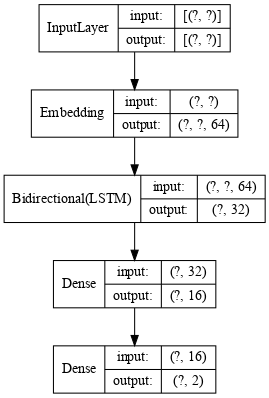

In [21]:
tf.keras.utils.plot_model(Model, show_shapes=True, dpi=74, show_layer_names=False)

## Training Model (with callback)


In [22]:
Model.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_path = 'save_models/best_model.hdf5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    verbose=0,
    save_best_only=True
)

earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=4,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

callback_list = [checkpoint_callback, earlystop_callback, reduce_lr]
history = Model.fit(training_data, batch_size=None, validation_data=validation_data, epochs=500, callbacks=callback_list)

Epoch 1/500
86/86 [==============================] - 2s 25ms/step - loss: 0.5903 - accuracy: 0.7406 - val_loss: 0.3812 - val_accuracy: 0.8473
Epoch 2/500
86/86 [==============================] - 2s 18ms/step - loss: 0.3019 - accuracy: 0.8781 - val_loss: 0.2601 - val_accuracy: 0.8886
Epoch 3/500
86/86 [==============================] - 1s 16ms/step - loss: 0.2315 - accuracy: 0.9115 - val_loss: 0.2016 - val_accuracy: 0.9192
Epoch 4/500
86/86 [==============================] - 2s 17ms/step - loss: 0.1879 - accuracy: 0.9255 - val_loss: 0.1625 - val_accuracy: 0.9460
Epoch 5/500
86/86 [==============================] - 1s 12ms/step - loss: 0.1621 - accuracy: 0.9400 - val_loss: 0.1496 - val_accuracy: 0.9508
Epoch 6/500
86/86 [==============================] - 1s 11ms/step - loss: 0.1448 - accuracy: 0.9522 - val_loss: 0.1255 - val_accuracy: 0.9587
Epoch 7/500
86/86 [==============================] - 1s 11ms/step - loss: 0.1301 - accuracy: 0.9565 - val_loss: 0.1126 - val_accuracy: 0.9646
Epoch 

##  Plot loss function and accuracy

<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


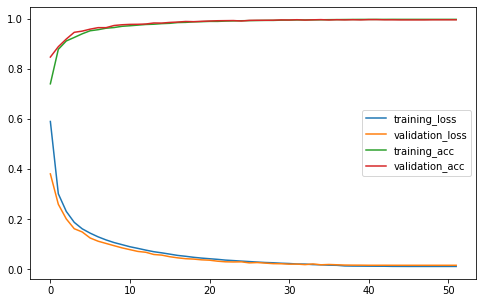

In [23]:
print(type(history.history))
print(history.history.keys())

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.plot(history.history['accuracy'], label='training_acc')
plt.plot(history.history['val_accuracy'], label='validation_acc')
plt.legend()
plt.show()

# Import model and Test on unseen data

In [24]:
best_model = tf.keras.models.load_model('save_models/best_model.hdf5')
best_model.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0007), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
test_data_text = '4-hydroxy-2-methyl-3-methylidene-6-oxocyclohexa-1,4-diene-1-carboxylic acid'
test_data_text_cut = '4|-|hydroxy|-|2|-|meth|yl|-|3|-|meth|yl|idene|-|6|-|oxo|cyclo|hex|a|-|1|,|4|-|di|ene|-|1|-|carboxylic acid'

In [26]:
_, my_y = create_dataset(test_data_text_cut)
myText_test = text_pred_preprocessing(test_data_text)

pred_test_proba = best_model.predict(myText_test)

pred_test = decode_label(pred_test_proba)
pred_test[0] = 1
my_y_decode = decode_label(my_y)

print(pred_test)
print(my_y_decode)

# Count same item between y (label) and pred (prediction)
elem_same = (pred_test == my_y_decode).sum()
print("\nSame =",elem_same,", Not Same =",pred_test.shape[0]-elem_same)

[1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0
 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0]
[1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0
 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]

Same = 73 , Not Same = 2


In [27]:
words = word_tokenize(test_data_text, pred_test)
print(words)
print('|'.join(words))

['4', '-', 'hydroxy', '-', '2', '-', 'meth', 'yl', '-', '3', '-', 'meth', 'yl', 'idene', '-', '6', '-', 'oxocyclo', 'hex', 'a', '-', '1', ',', '4', '-', 'di', 'ene', '-', '1', '-', 'carboxyl', 'ic acid']
4|-|hydroxy|-|2|-|meth|yl|-|3|-|meth|yl|idene|-|6|-|oxocyclo|hex|a|-|1|,|4|-|di|ene|-|1|-|carboxyl|ic acid


# Function Confusion Matrix visualization

In [28]:
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Plot Confusion Matrix

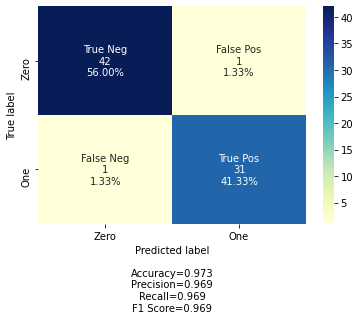

In [29]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Zero", "One"]
make_confusion_matrix(tf.math.confusion_matrix(my_y_decode, pred_test, num_classes=2).numpy(), 
                      group_names=labels,
                      categories=categories, cmap='YlGnBu')

## BLEU Score

In [30]:
reference = test_data_text_cut.split('|')
print(reference)

['4', '-', 'hydroxy', '-', '2', '-', 'meth', 'yl', '-', '3', '-', 'meth', 'yl', 'idene', '-', '6', '-', 'oxo', 'cyclo', 'hex', 'a', '-', '1', ',', '4', '-', 'di', 'ene', '-', '1', '-', 'carboxylic acid']


In [31]:
import nltk
score = nltk.translate.bleu_score.sentence_bleu([reference],words)
print(score)

0.8498644646741501
